In [28]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, classification_report, confusion_matrix, roc_curve, auc, f1_score


### Funções Random Forest

In [29]:
def RandomForest(df):
    X = df.drop('diagnostico', axis=1)
    y = df['diagnostico']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    
    params_grid = {'bootstrap': [True, False],
                    'max_depth': [20, 40, 60, 80],
                    'max_features': ['auto', 'sqrt'],
                    'min_samples_leaf': [1, 2, 4],
                    'min_samples_split': [2, 5, 10],
                    'n_estimators': [100, 200]}
    
    rf = RandomForestClassifier()
    grid_classifier = RandomizedSearchCV(estimator = rf, param_distributions = params_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
    grid_classifier.fit(X_val, y_val)
    
    best_parameters = grid_classifier.best_params_
    
    model = RandomForestClassifier(**best_parameters)
    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)
    
    test_accuracy = accuracy_score(y_test, pred)
    cm = confusion_matrix(y_test, pred)
    ppv = precision_score(y_test, pred)
    sensit = recall_score(y_test, pred)
    specificity = cm[0,0] / (cm[0,0] + cm[0,1])
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, pred)
    print(f"F1-Score: {f1:.4f}")
    print(f"Acurácia: {test_accuracy:.4f}")
    print(f"PPV (Precision): {ppv:.4f}")
    print(f"Sensibilidade (Recall): {sensit:.4f}")
    print(f"Especificidade: {specificity:.4f}")
    print(f"AUC: {auc_score:.4f}")    
    print(classification_report(y_test,pred))
    print(confusion_matrix(y_test, pred))
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Sem Sepse', 'Com Sepse'], yticklabels=['Sem Sepse', 'Com Sepse'])
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.title('Matriz de Confusão')
    plt.show()

In [30]:
def RandomForest_Over(df):
    X = df.drop('diagnostico', axis=1)
    y = df['diagnostico']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    
    # Contagem de instâncias antes do oversampling
    original_counts = y_train.value_counts()
    
    # Aplicar oversampling aleatório apenas nos dados de treino
    ros = RandomOverSampler(random_state=42)
    X_train_res, y_train_res = ros.fit_resample(X_train, y_train)
    
    # Contagem de instâncias após o oversampling
    resampled_counts = y_train_res.value_counts()
    
    df_original = original_counts.reset_index()
    df_original.columns = ['Classe', 'Contagem']
    df_original['Dataset'] = 'Original'

    df_resampled = resampled_counts.reset_index()
    df_resampled.columns = ['Classe', 'Contagem']
    df_resampled['Dataset'] = 'Balanceada'

    # Concatenar os DataFrames
    df_combined = pd.concat([df_original, df_resampled])

    # Criar uma nova coluna para agrupar por Classe e Dataset
    df_combined['Classes'] = df_combined['Classe'].astype(str) + ' - ' + df_combined['Dataset']

    # Plotar o gráfico de barras comparativo
    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(x='Classes', y='Contagem', data=df_combined, palette=['skyblue', 'lightgreen'])

    # Adicionar os valores em cima de cada barra
    for p in barplot.patches:
        barplot.annotate(f'{int(p.get_height())}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='baseline', 
                        fontsize=11, color='black', 
                        xytext=(0, 5), 
                        textcoords='offset points')

    plt.title('Validação do Oversampling')
    plt.show()
    
    params_grid = {'bootstrap': [True, False],
                    'max_depth': [20, 40, 60, 80],
                    'max_features': ['auto', 'sqrt'],
                    'min_samples_leaf': [1, 2, 4],
                    'min_samples_split': [2, 5, 10],
                    'n_estimators': [100, 200]}
    
    rf = RandomForestClassifier()
    grid_classifier = RandomizedSearchCV(estimator=rf, param_distributions=params_grid, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)
    grid_classifier.fit(X_val, y_val)
    
    best_parameters = grid_classifier.best_params_
    
    model = RandomForestClassifier(**best_parameters)
    # Treinar o modelo com os dados balanceados
    model.fit(X_train_res, y_train_res)
    
    pred = model.predict(X_test)
    
    test_accuracy = accuracy_score(y_test, pred)
    cm = confusion_matrix(y_test, pred)
    ppv = precision_score(y_test, pred)
    sensit = recall_score(y_test, pred)
    specificity = cm[0,0] / (cm[0,0] + cm[0,1])
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, pred)
    print(f"F1-Score: {f1:.4f}")
    print(f"Acurácia: {test_accuracy:.4f}")
    print(f"PPV (Precision): {ppv:.4f}")
    print(f"Sensibilidade (Recall): {sensit:.4f}")
    print(f"Especificidade: {specificity:.4f}")
    print(f"AUC: {auc_score:.4f}")  
        
    print(classification_report(y_test, pred))
    print(confusion_matrix(y_test, pred))
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Sem Sepse', 'Com Sepse'], yticklabels=['Sem Sepse', 'Com Sepse'])
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.title('Matriz de Confusão')
    plt.show()
    

### Sem Tratar Missing

In [ ]:
df_final = pd.read_csv('df_final.csv')

In [ ]:
RandomForest(df_final)

In [ ]:
RandomForest_Over(df_final)

### Valores Normais

In [ ]:
df_normal = pd.read_csv('df_normal.csv')

In [ ]:
RandomForest(df_normal)

In [ ]:
RandomForest_Over(df_normal)

### KNN

In [ ]:
df_knn = pd.read_csv('df_knn.csv')

In [ ]:
RandomForest(df_knn)

In [ ]:
RandomForest_Over(df_knn)

### Media

In [ ]:
df_media = pd.read_csv('df_media.csv')

In [ ]:
RandomForest(df_media)

In [ ]:
RandomForest_Over(df_media)

### Mediana

In [ ]:
df_mediana = pd.read_csv('df_mediana.csv')

In [ ]:
RandomForest(df_mediana)

In [ ]:
RandomForest_Over(df_mediana)

### Moda

In [ ]:
df_moda = pd.read_csv('df_moda.csv')

In [ ]:
RandomForest(df_moda)

In [ ]:
RandomForest_Over(df_moda)

### Regressão

In [31]:
df_regressao = pd.read_csv('df_regressao.csv')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s

[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; t

/home/vip/grad/23/leticia.ribeiro/miniconda3/envs/uti/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
270 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
175 fits failed with the following error:
Traceback (most recent call last):
  File "/home/vip/grad/23/leticia.ribeiro/miniconda3/envs/uti/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vip/grad/23/leticia.ribeiro/miniconda3/envs/uti/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/vip/grad/23/leticia.ribeiro/miniconda3/envs/uti/l

F1-Score: 0.3952
Acurácia: 0.9846
PPV (Precision): 0.9612
Sensibilidade (Recall): 0.2487
Especificidade: 0.9998
AUC: 0.9730
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     19244
         1.0       0.96      0.25      0.40       398

    accuracy                           0.98     19642
   macro avg       0.97      0.62      0.69     19642
weighted avg       0.98      0.98      0.98     19642

[[19240     4]
 [  299    99]]


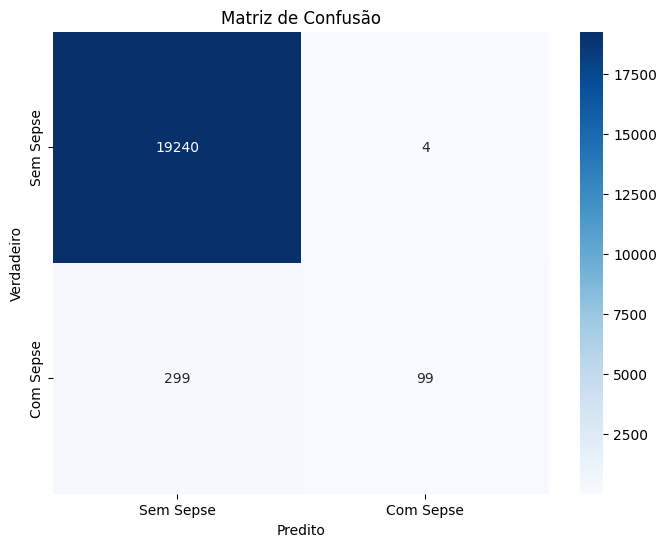

In [6]:
RandomForest(df_regressao)

/tmp/ipykernel_1442137/3772075964.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Classes', y='Contagem', data=df_combined, palette=['skyblue', 'lightgreen'])
/tmp/ipykernel_1442137/3772075964.py:33: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  barplot = sns.barplot(x='Classes', y='Contagem', data=df_combined, palette=['skyblue', 'lightgreen'])


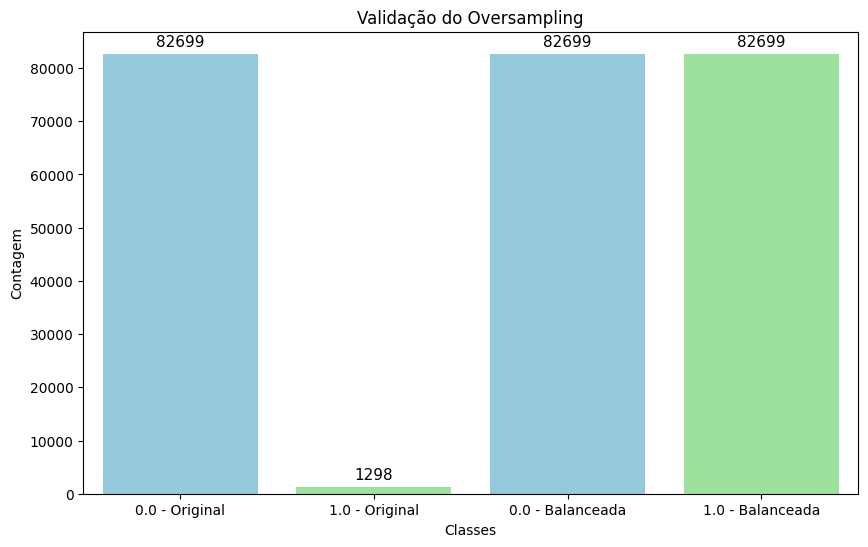

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200;

KeyboardInterrupt: 

In [32]:
RandomForest_Over(df_regressao)